In [1]:
import numpy as np
import pandas as pd
import json
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pickle as pkl
import imblearn
np.random.seed(1332)
from sklearn.datasets import load_boston
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
#import seaborn as sns
import statsmodels.api as sm
%matplotlib inline
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import sys                                               #### Filling the missing values using KNN because the dataset is very less
from impyute.imputation.cs import fast_knn
import imblearn                                      ### sampling the data using the smote method
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
import sklearn
import xgboost
from xgboost import XGBClassifier              ### XGBoost classification method
from xgboost import XGBRegressor
import sklearn
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from xgboost import cv


In [2]:
excel = pd.ExcelFile('Coronna Data CERTAIN with KVB edits.xlsx')
df = pd.read_excel(excel, 'BL+3M')

In [3]:
df = df.drop(columns = ['SubjectID', 'CDate', 'Match'])    ### Unique values
df = df.drop(columns = ['SubjectID.1', 'UNMC_id.1', 'CDate.1', 'init_group.1', 'grp.1', 'UNMC_id.2', 'grp.2', 'init_group.2', 'CDate.1', 'futime.1'])    ### Duplicate values
df = df.drop(columns = ['init_group', 'futime'])    ### same values for all rows

In [4]:
df.isnull().mean()[df.isnull().mean() > 0.7]   

statin_use          1.000000
smkyrs              0.753378
numcigs             0.783784
rfstatus_impute     0.996622
ccpstatus_impute    0.972973
statin_use.1        1.000000
dtype: float64

In [5]:
df = df.drop(columns = ['statin_use', 'rfstatus_impute', 'ccpstatus_impute', 'statin_use.1', 'smkyrs', 'numcigs'])  ### Dropping columns who have null values greater than 70%

In [6]:
df = df.drop(columns = ['3MResponse','DAS28-CRP 3m'])

In [7]:
df = df.rename(columns={"usresultsIgA.1": "usresultsIgA_BL", "usresultsIgG.1": "usresultsIgG_BL", "usresultsIgM.1": "usresultsIgM_BL", 'seatedbp1.1': 'seatedbp1_BL',
                              'seatedbp2.1': 'seatedbp2_BL', 'pres_mtx.1': 'pres_mtx_BL', 'pres_arava.1': 'pres_arava_BL', 'pres_azulfidine.1': 'pres_azulfidine_BL', 
                              'pres_plaquenil.1': 'pres_plaquenil_BL', 'pres_imuran.1': 'pres_imuran_BL', 'pres_minocin.1': 'pres_minocin_BL', 'pres_pred.1': 'pres_pred_BL',
                              'statin_use.1': 'statin_use_BL', 'tender_jts_28.1': 'tender_jts_28_BL', 'BLswollen_jts_28': 'swollen_jts_28_BL',
                              'BLmd_global_assess': 'md_global_assess_BL', 'BLpt_global_assess': 'pt_global_assess_BL', 'BLdi': 'di_BL', 'BLpt_pain': 'pt_pain_BL', 'BLusresultsCRP': 'usresultsCRP_BL',
                              'DAS28-CRP BL': 'DAS28-CRP_BL', })     ### Renaming some columns. Not sure why - did it because previous student did it

In [8]:
df = df.drop('UNMC_id',1)
final_df = df
model_label = LabelEncoder()
final_df['grp'] = model_label.fit_transform(final_df['grp'].astype('str'))
final_df['gender'] = model_label.fit_transform(final_df['gender'].astype('str'))
final_df['final_education'] = model_label.fit_transform(final_df['final_education'].astype('str'))
final_df['race_grp'] = model_label.fit_transform(final_df['race_grp'].astype('str'))
final_df['newsmoker'] = model_label.fit_transform(final_df['newsmoker'].astype('str'))
final_df['drinker'] = model_label.fit_transform(final_df['drinker'].astype('str'))
final_df['ara_func_class'] = model_label.fit_transform(final_df['ara_func_class'].astype('str'))

/state/partition1/job-14623479/ipykernel_266138/2061900728.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df = df.drop('UNMC_id',1)


In [9]:
X = final_df.drop('DAS28-CRP_BL',1) 
y = final_df['DAS28-CRP_BL']

/state/partition1/job-14623479/ipykernel_266138/478981959.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = final_df.drop('DAS28-CRP_BL',1)


In [10]:
def KNN(new_df):
    sys.setrecursionlimit(100000) 
    imputed_training=fast_knn(new_df.values, k=15)
    return imputed_training
imputed_training = KNN(X)
c = list(X.columns)
df_without_nulls = pd.DataFrame(imputed_training, columns=c)

In [11]:
labels = ['grp','gender','final_education','race_grp','newsmoker','drinker','ara_func_class']     ### normalizing the dataset

for i in df_without_nulls.columns:
    if i not in labels:
        mean = df_without_nulls[i].mean()
        std = df_without_nulls[i].std()
        df_without_nulls[i] = (df_without_nulls[i] - mean) / std

In [12]:
labels = ['pres_imuran','pres_minocin','num_tnf','num_nontnf','hxunstab_ang','pres_minocin_BL']    #### This columns has same value for every row so when I divide by mean and std the value goes to infinity
for i in labels:
    df_without_nulls = df_without_nulls.drop(i,1)

/state/partition1/job-14623479/ipykernel_266138/1646036866.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df_without_nulls = df_without_nulls.drop(i,1)


In [13]:
rs = 1006
X_train_norm, X_val_norm, Y_train, Y_val = train_test_split(df_without_nulls, y, random_state=rs, test_size=0.1)     ### splitting the dataset into training and test set

In [14]:
model4 = None
def xgboost(X_train_norm, X_test,Y_train, Y_test):
    global model4
    model4 = XGBRegressor(n_estimators = 200, random_state=rs, subsample=0.8, max_depth=50, eta=0.5, gamma=1, min_child_weight=10, alpha=1)
    model4.fit(X_train_norm, Y_train)
    results = cross_val_score(model4, X_train_norm, Y_train, cv=10)
    print("sklearn:::", results, results.mean())
    print(f"Training accuracy is {model4.score(X_train_norm, Y_train)}")
    print(f"Testing accuracy is {model4.score(X_test, Y_test)}")
xgboost(X_train_norm, X_val_norm, Y_train, Y_val)

sklearn::: [0.88575484 0.86244659 0.91367525 0.82435995 0.85369141 0.9338998
 0.87220153 0.91847968 0.85297141 0.92852269] 0.8846003153267237
Training accuracy is 0.9410663939249209
Testing accuracy is 0.9152229111743155


In [15]:
model3 = None
def random_forest(X_train_norm, X_test, Y_train,Y_test):
    global model3
    model3 = sklearn.ensemble.RandomForestRegressor(n_estimators=474, oob_score = True, criterion='squared_error',max_depth=90, min_samples_split=10, random_state=rs, max_features='auto', min_samples_leaf = 6)
    model3.fit(X_train_norm, Y_train)
    print(model3.oob_score_)
    print(f"Training accuracy is {model3.score(X_train_norm, Y_train)}")
    print(f"Testing accuracy is {model3.score(X_test, Y_test)}")
random_forest(X_train_norm, X_val_norm, Y_train, Y_val)

0.8517043261702437
Training accuracy is 0.9387644146964511
Testing accuracy is 0.8695232095100328


/ext3/miniconda3/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [16]:
model5 = None
def linear_regress(X_train_norm, X_test, Y_train,Y_test):
    global model5
    model5 = sklearn.linear_model.Ridge(random_state = rs)
    model5.fit(X_train_norm, Y_train)
    results = cross_val_score(model5, X_train_norm, Y_train, cv=10, scoring="r2")
    
    print("sklearn:::", results, results.mean())
    print(f"Training accuracy is {model5.score(X_train_norm, Y_train)}")
    print(f"Testing accuracy is {model5.score(X_test, Y_test)}")
linear_regress(X_train_norm, X_val_norm, Y_train, Y_val)

sklearn::: [0.92278997 0.71817165 0.77098727 0.88593172 0.84242914 0.93588937
 0.91447054 0.90972533 0.79973529 0.80629707] 0.850642734108165
Training accuracy is 0.9434655227397327
Testing accuracy is 0.915203957410894


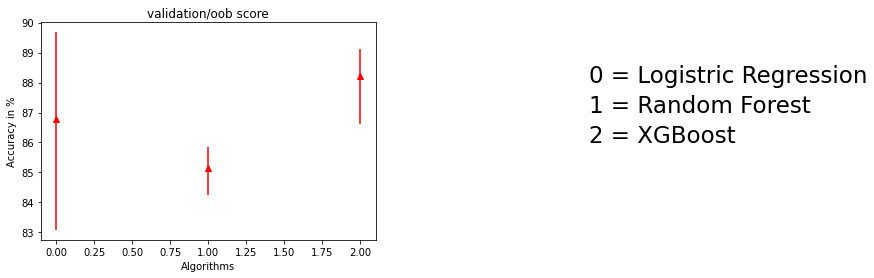

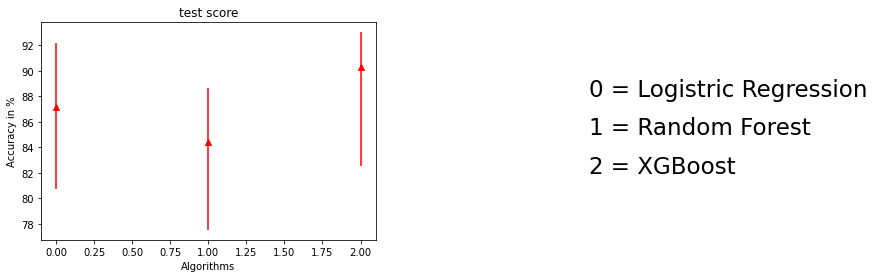

In [18]:
x = (0,1,2)
y = (86.78, 85.15, 88.23)
plt.figure()
yerr = np.array([(3.7,2.9),(0.9, 0.7), (1.6, 0.9)]).T
plt.errorbar(x, y, yerr, fmt='r^')
plt.title("validation/oob score")
plt.xlabel("Algorithms")
plt.ylabel("Accuracy in %")
plt.text(3.5, 88, '0 = Logistric Regression', fontsize = 23)
plt.text(3.5, 87, '1 = Random Forest', fontsize = 23)
plt.text(3.5, 86, '2 = XGBoost', fontsize = 23)
#plt.legend(['First line', 'Second line','Third Line'])
plt.show()

x_test = [0, 1, 2]
y_test = [87.2, 84.43, 90.32]
plt.figure()
y_err_test = np.array([(6.48, 5),(6.9, 4.2), (7.79, 2.7)]).T
plt.errorbar(x_test, y_test, y_err_test, fmt='r^')
plt.title("test score")
plt.xlabel("Algorithms")
plt.ylabel("Accuracy in %")
plt.text(3.5, 88, '0 = Logistric Regression', fontsize = 23)
plt.text(3.5, 85, '1 = Random Forest', fontsize = 23)
plt.text(3.5, 82, '2 = XGBoost', fontsize = 23)
plt.show()